In [2]:
from pprint import pprint

from gensim.corpora.dictionary import Dictionary
from news_nlp import get_tfidf
from news_nlp_gensim import preprocess, get_doc_similarity_scores
from news import json_dir
import os
import json

urls = list()
url_dict = dict()
docs = list()

for f in os.listdir(json_dir):
    fp = os.path.join(json_dir, f)
    if os.path.isfile(fp) and '--nlp--applied' in fp:    
        print(f"loading {fp}")
        with open(fp, 'r', encoding='utf8') as fin:
            n_list = json.load(fin)
        for n in n_list:
            # pprint(n)
            doc = n['ni']['header'] + ' '+ n['ni']['summary']
            urls.append(n['ni']['url'])
            url_dict[n['ni']['url']] = doc
            docs.append(doc)

docs_idx = [[i,d] for i,d in enumerate(docs)]

loading d:\dev local\news_summary\out\json\https___edition_cnn_com_business--nlp--applied
loading d:\dev local\news_summary\out\json\https___www_cnbc_com_finance_--nlp--applied
loading d:\dev local\news_summary\out\json\https___www_reuters_com_business_finance_--nlp--applied.json


In [17]:
d_scores = list()

# DOCUMENT SIMILARITY
found_ids = set()
found_groups = list()

def process_doc(docs_idx, idx, doc):
    these_docs = [
        [i,d] for i,d in docs_idx if i != idx
        # and i not in found_ids
    ]
    this_group = [[idx, doc]]
    found_ids.add(idx)
    if these_docs:
        ds_tfidf = get_tfidf(doc ,[i_d[1] for i_d in these_docs])
        ds_gensim = [1] * len(ds_tfidf)
        # ds_gensim = get_doc_similarity_scores(
        #     preprocess(doc), [preprocess(i_d[1]) for i_d in these_docs]
        # )
        # print(document_scores[0])
        i_s_d = [
            [i_d[0], s_tfidf, s_gensim, i_d[1]]
            for i_d, s_tfidf, s_gensim
            in zip(these_docs, ds_tfidf, ds_gensim)
            # if s_tfidf * s_gensim > 0.1
            # if s_tfidf * s_gensim > 0.2
        ]
        i_s_d.sort(reverse=True, key=lambda x: x[1] * x[2])
        if i_s_d:
            print(doc[:100])
            c = 0
            for i, s_tfidf, s_gensim, d in i_s_d:
                # c += 1
                # if c > 5:
                #     break
                d_scores.append([s_tfidf, s_gensim])
                found_ids.add(i)
                # this_group.append([i, d])
                print("--", i, round(s_tfidf * s_gensim,3), d[:100])
            # input("enter to continue...")
    found_groups.append(this_group)

t_list = list()
from threading import Thread
for idx, doc in enumerate(docs):
    # process_doc(docs_idx, idx, doc)
    t = Thread(target=process_doc, args=[docs_idx, idx, doc])
    t_list.append(t)
    t.start()
    if len(t_list) >= 8:
        for t_ in t_list:
            t_.join()
        t_list = list()
for t_ in t_list:
    t_.join()


    
print(f"found {len(docs_idx)} docs, {len(found_groups)} groups")


Lithuania says throw away Chinese phones due to censorship concerns Flagship phones sold in Europe b
-- 2Salesforce's Indian rival Freshworks valued at $10 billion in Wall Street IPO An Indian company that
--  0.061 Russia urged to pump more gas to Europe as energy prices soar The Paris-based group said in a statem
--44 0.213 SoftBank says new Latin America fund has at least $3 billion to invest in regional start-ups After a
 61 0.06 -- 17 EU not leading by example on green investing, auditors say The European Union is not doing enough to
-- 4 0.0510.139  China's Evergrande meets crucial debt deadline but another looms China's Evergrande Group will pay iBillionaire Peter Thiel could be forced to pull $5 billion from his retirement account, if House bil
-- 19 0.136 Suspicious trades were made before Goldman’s $2.2 billion acquisition of GreenSky, options experts s
-- Google expands in New York with $2.1 billion office purchase The move comes even as the company embr
-- 9 0.19 
-- 67 0.0

(4556, 2)


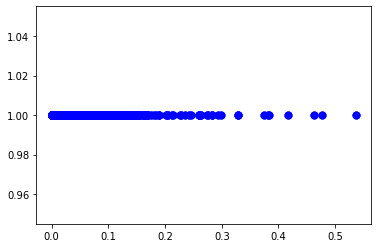

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


X = np.array(d_scores)
print(X.shape)

plt.scatter(X[:,0], X[:,1], s = 50, c = 'b')
plt.show()


[[0.1676354  1.        ]
 [0.02440167 1.        ]]
[0.1676354 1.       ]
[0.02440167 1.        ]


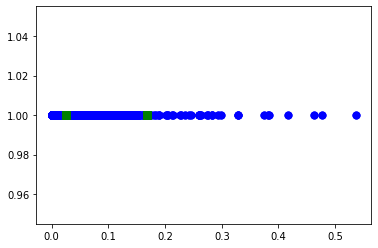

In [19]:
from sklearn.cluster import KMeans
Kmean = KMeans(n_clusters=2)
Kmean.fit(X)

print(Kmean.cluster_centers_)

plt.scatter(X[:,0], X[:,1], s = 50, c = 'b')

for i in Kmean.cluster_centers_:
    plt.scatter(i[0], i[1], s = 50, c = 'g', marker='s')
    print(i)
plt.show()

In [20]:
min_ds = 1
for l, ds in zip(Kmean.labels_, d_scores):
    if l == 1:
        # print(ds)
        if min_ds > ds[0]:
            min_ds = ds[0]
print("final KMeans min for high ds", min_ds)

Y = Kmean.labels_

final KMeans min for high ds 0.0


In [21]:
from sklearn import svm

clf = svm.SVC(kernel='linear')
clf.fit(X, Y)
w = clf.coef_[0]
x_0 = -clf.intercept_[0]/w[0]
margin = w[0]
print(x_0, margin)

0.15340770596103756 -12.151685014034717


(4288, 2) (268, 2)


d:\dev local\news_summary\env\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


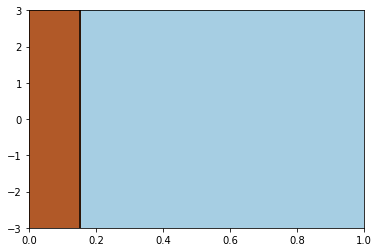

In [22]:
pos = list()
neg = list()
for l, ds in zip(Kmean.labels_, d_scores):
    if l == 1:
        pos.append(ds)
    else:
        neg.append(ds)
pos = np.array(pos)
neg = np.array(neg)

print(pos.shape, neg.shape)

plt.figure()
x_min, x_max = np.floor(X.min()), np.ceil(X.max())
y_min, y_max = -3, 3
yy = np.linspace(y_min, y_max)
XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
Z = clf.predict(np.c_[XX.ravel(), np.zeros(XX.size)]).reshape(XX.shape)
plt.pcolormesh(XX, YY, Z, cmap=plt.cm.Paired)
plt.plot(x_0*np.ones(shape=yy.shape), yy, 'k-')
plt.plot(x_0*np.ones(shape=yy.shape) - margin, yy, 'k--')
plt.plot(x_0*np.ones(shape=yy.shape) + margin, yy, 'k--')
plt.scatter(pos, .3 + np.zeros(shape=pos.shape), s=80, marker='o', facecolors='none')
plt.scatter(neg, -.3 + np.zeros(shape=neg.shape), s=80, marker='^', facecolors='none')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()
